Loading: \\saxolapxxxx\Users\Matilde\Desktop\Thesis_project_2.0_EDIT\topic0_per_doc_filtered.csv
Columns in file: ['id', 'subreddit', 'kind', 'dt', 'clean_for_topics', 'parent_topic', 'parent_topic_name', 'topic', 'topic_name']
Shape: (102290, 9)
Using 'dt' as datetime column.
Dropped 0 rows with invalid datetime.
Topic value counts (head):
topic
0    72234
2     3529
1     3496
3     3305
4     2856
5     1128
6     1101
7      989
9      690
8      674
Name: count, dtype: int64
Time range: 2020-05-01 00:00:00 → 2025-09-01 00:00:00


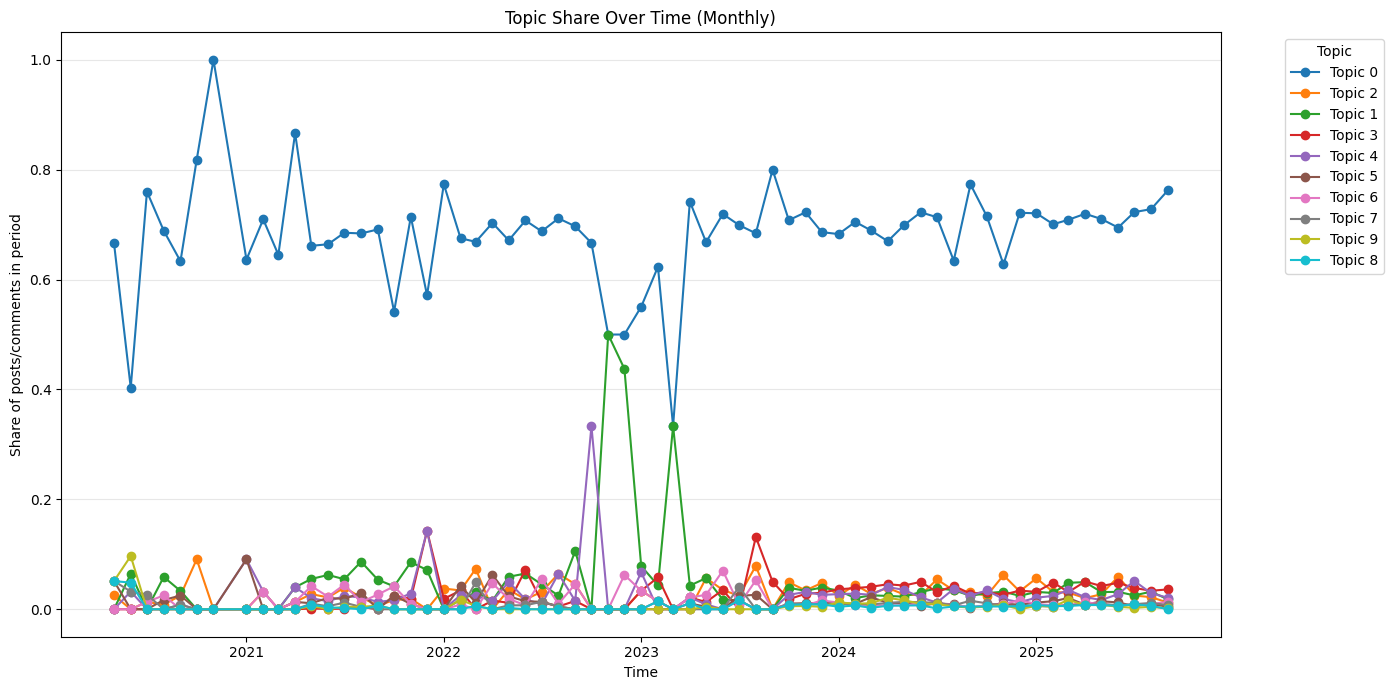


 Saved results:
   • CSV  → \\saxolapxxxx\Users\Matilde\Desktop\Thesis_project_2.0_EDIT\results\topic_trends_monthly_mts30.csv
   • Plot → \\saxolapxxxx\Users\Matilde\Desktop\Thesis_project_2.0_EDIT\results\topic_trends_monthly_mts30.png


In [ ]:
# STEP 10 — Topic Trend Analysis (and Save Results)
# Input:  topics_per_doc_mts30_fast_semicolon.csv
# Output: /results/topic_trends_<freq>_mts30.csv, /results/topic_trends_<freq>_mts30.png

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Paths & basic config

TOPICS_PER_DOC_CSV = Path("topic0_per_doc_filtered.csv")
RESULTS_DIR = Path("results")  # folder for outputs
RESULTS_DIR.mkdir(exist_ok=True)

TOP_N_TOPICS = 10        # how many top topics to plot
FREQ = "M"               # "M" = weekly, "M" = monthly

# Map FREQ to a human-readable label for filenames
FREQ_LABEL_MAP = {"W": "weekly", "M": "monthly"}
freq_label = FREQ_LABEL_MAP.get(FREQ, FREQ.lower())

# Load data

print(f"Loading: {TOPICS_PER_DOC_CSV.resolve()}")
df = pd.read_csv(TOPICS_PER_DOC_CSV, sep=";")

print("Columns in file:", df.columns.tolist())
print("Shape:", df.shape)


# Find & parse date column

CANDIDATE_DATE_COLS = ["dt"]

date_col = None
for col in CANDIDATE_DATE_COLS:
    if col in df.columns:
        date_col = col
        break

if date_col is None:
    raise ValueError(
        "No date column found. "
        f"Tried: {CANDIDATE_DATE_COLS}. "
        "Please rename your datetime column to one of these or adjust the list."
    )

print(f"Using '{date_col}' as datetime column.")

if np.issubdtype(df[date_col].dtype, np.number):
    df["dt"] = pd.to_datetime(df[date_col], unit="s", utc=True)
else:
    df["dt"] = pd.to_datetime(df[date_col], utc=True, errors="coerce")

before = len(df)
df = df.dropna(subset=["dt"])
after = len(df)
print(f"Dropped {before - after} rows with invalid datetime.")

df["dt"] = df["dt"].dt.tz_convert(None)


# Basic sanity checks

if "topic" not in df.columns:
    raise ValueError("Expected a 'topic' column from BERTopic in topics_per_doc.csv")

print("Topic value counts (head):")
print(df["topic"].value_counts().head(10))

# Create time bins (weekly / monthly)


df["time_bin"] = df["dt"].dt.to_period(FREQ).dt.start_time
print("Time range:", df["time_bin"].min(), "→", df["time_bin"].max())


# Aggregate counts per topic per time_bin


topic_trends = (
    df.groupby(["topic", "time_bin"])
      .size()
      .reset_index(name="count")
)

topic_trends["share"] = (
    topic_trends["count"] /
    topic_trends.groupby("time_bin")["count"].transform("sum")
)


# Select top N topics overall

total_counts = (
    topic_trends.groupby("topic")["count"]
    .sum()
    .sort_values(ascending=False)
)

top_topics = total_counts.head(TOP_N_TOPICS).index.tolist()
topic_trends_top = topic_trends[topic_trends["topic"].isin(top_topics)].copy()
topic_order = total_counts.loc[top_topics].index.tolist()


# Pivot for plotting


pivot_share = (
    topic_trends_top
    .pivot(index="time_bin", columns="topic", values="share")
    .fillna(0.0)
    .sort_index()
)[topic_order]


# Plot and SAVE


plt.figure(figsize=(14, 7))
for topic in pivot_share.columns:
    plt.plot(
        pivot_share.index,
        pivot_share[topic],
        marker="o",
        linewidth=1.5,
        label=f"Topic {topic}"
    )

plt.title(f"Topic Share Over Time ({freq_label.capitalize()})")
plt.xlabel("Time")
plt.ylabel("Share of posts/comments in period")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.grid(True, axis="y", alpha=0.3)

# --- Save plot ---
PLOT_PATH = RESULTS_DIR / f"topic_trends_{freq_label}_mts30.png"
plt.savefig(PLOT_PATH, dpi=300, bbox_inches="tight")
plt.show()


# Save aggregated data


OUTPUT_TRENDS_CSV = RESULTS_DIR / f"topic_trends_{freq_label}_mts30.csv"
topic_trends.to_csv(OUTPUT_TRENDS_CSV, index=False, sep=";")

print("\n Saved results:")
print(f"   • CSV  → {OUTPUT_TRENDS_CSV.resolve()}")
print(f"   • Plot → {PLOT_PATH.resolve()}")
